## Описание

Мобильная игра зарабатывает на показе рекламы. 

Есть несколько форматов:
+ `int` – полноэкранная реклама; 
+ `banner` – горизонтальный баннер, висит внизу экрана пока юзер играет;
+ `rv` – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы.

Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной
рекламы, рекламную сеть от которой был показ и др.

**Задача**

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров.

## Предпросмотр данных

In [1]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default='svg'

In [2]:
# загрузка данных
data = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')

In [3]:
data.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [5]:
data.shape

(860079, 16)

In [6]:
print(f'Процент пустых данных о городе пользователя {round(len(data[data.city.isna()]) / len(data) * 100, 2)}')

Процент пустых данных о городе пользователя 37.64


###### К сожалению в данных о городах находится огромное количество пропусков 37,5%. Зацепся за какие-то данные что бы заполнить в ручную я не смог. Возможно стоило  обучить мультикласс модель и разметить с её помощью.

######  В столбце `event_json`  находится много нужной информации, которую нужно извлечь.

### Преобразования

In [7]:
# заменю пропуки в городах на строку, что бы можно было в дальнейшем их суммировать и т.д и не потерять данные
data.city = data.city.fillna('Нет данных')

In [8]:
# функция для извелчения нужных данных из event_json
def get_from_json(key):
    keys_list = ['ad_type', 'placement', 'view_index', 'session_view_index', 'cur_ticks', 'session_length', 'revenue',
                 'ads_ltv', 'ecpm_sma', 'normalized_ecpm_sma', 'value', 'currency', 'ad_country_code', 'network_name',
                 'ad_unit_id', 'ad_network_placement', 'creativeId']
    result = []
    for i in range(len(data)):
        json_list = data.event_json[i][1:-1].replace('"', '').split(',')
        json_result = [json_list[i].split(':') for i in range(len(json_list))]
        result.append(json_result[keys_list.index(key)][1])
    return result

In [9]:
#добавление столбцов извлечённых из json
data['ad_type'] = get_from_json('ad_type')
data['revenue'] = get_from_json('revenue')
data.revenue = data.revenue.astype('float64')
data['ecpm'] = data.revenue * 1000

In [10]:
# проверка на добавление новых столбцов
data.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,revenue,ecpm
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,0.000510,0.510313
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,0.000510,0.510313
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,banner,0.002386,2.386163
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa,int,0.013894,13.893784
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,Нет данных,banner,0.006828,6.827570


### Создание новых дф по типу рекламы

###### Для удобсвта создаётся 3 новых дф под каждый вид рекламы

In [11]:
data_banner = data[data.ad_type == 'banner']
data_int = data[data.ad_type == 'int']
data_rv = data[data.ad_type == 'rv']

In [12]:
print(f'Процент горизонтальных баннеров : {round(len(data_banner) / len(data) * 100, 2)}',
      f'Процент полноэкранной рекламы : {round(len(data_int) / len(data) * 100, 2)}',
      f'Процент видео, которое юзер смотрит по желанию : {round(len(data_rv) / len(data) * 100, 2)}', sep='\n')

Процент горизонтальных баннеров : 94.87
Процент полноэкранной рекламы : 4.37
Процент видео, которое юзер смотрит по желанию : 0.75


## Распределение средних eCPM-ов юзеров

In [13]:
# группировка с агрегирующей функцией
mean_user_banner = data_banner.groupby('profile_id')['ecpm'].mean().reset_index()
mean_user_int = data_int.groupby('profile_id')['ecpm'].mean().reset_index()
mean_user_rv = data_rv.groupby('profile_id')['ecpm'].mean().reset_index()

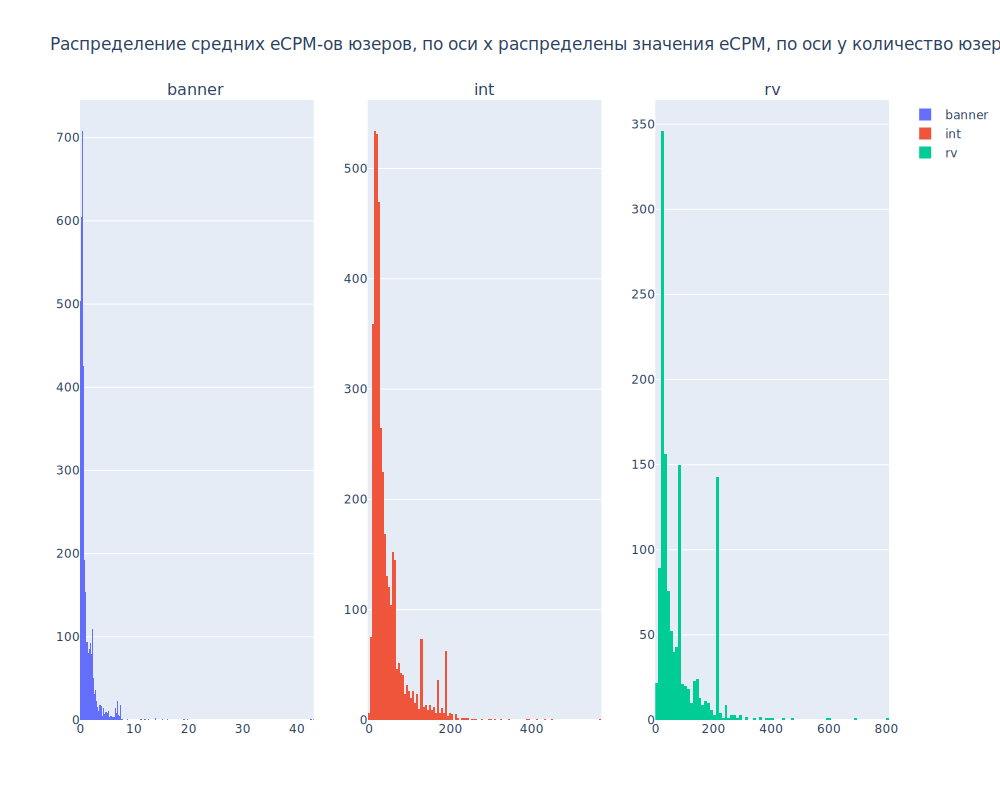

In [14]:
# график распределния средних
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Histogram(x=mean_user_banner.ecpm,
              y=mean_user_banner.profile_id, name='banner'), row=1, col=1)

fig.add_trace(go.Histogram(x=mean_user_int.ecpm,
              y=mean_user_int.profile_id, name='int'), row=1, col=2)

fig.add_trace(go.Histogram(x=mean_user_rv.ecpm,
              y=mean_user_rv.profile_id, name='rv'), row=1, col=3)

fig.update_layout(height=800, width=1000,
                  title_text='Распределение средних eCPM-ов юзеров, по оси x распределены значения eCPM, по оси y количество юзеров')
fig.show()

###### В banner рекламе наибольшее количество просмотров, но среднее eCPM на юзера мало из низкой прибыли такой рекламы. Противополжная ситуация с видео рекламой за бонусы. А реклама на весь экран имеет хорошее соотношение промотров и средней eCpm. Скорее всего она является самой прибыльной. 

## Cредние eCPM-ы по городам, версиям ОС

### Cредние eCPM-ы по городам

In [15]:
# таюлицы для графика с городами
mean_city_banner = data_banner.groupby('city')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)
mean_city_int = data_int.groupby('city')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)
mean_city_rv = data_rv.groupby('city')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)

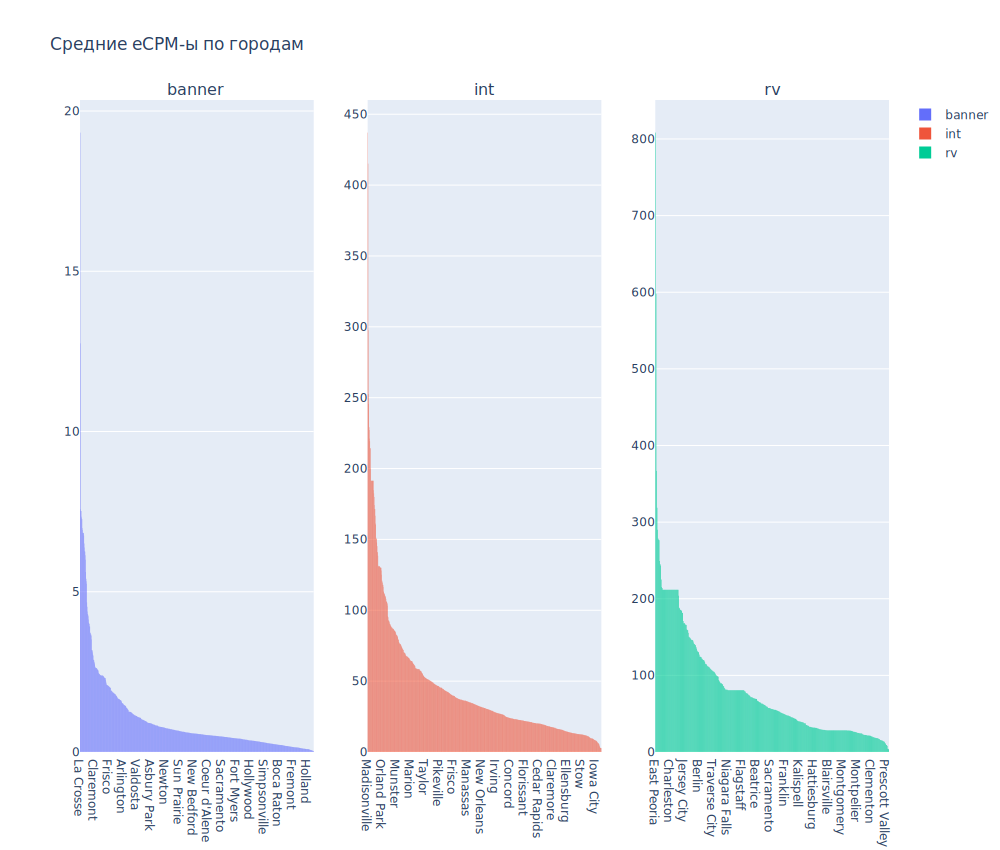

In [16]:
# график распределния средних по городам
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Histogram(x=mean_city_banner.city,
              y=mean_city_banner.ecpm, name='banner', histfunc='avg'), row=1, col=1)

fig.add_trace(go.Histogram(x=mean_city_int.city,
              y=mean_city_int.ecpm, name='int', histfunc='avg'), row=1, col=2)

fig.add_trace(go.Histogram(x=mean_city_rv.city, y=mean_city_rv.ecpm,
              name='rv', histfunc='avg'), row=1, col=3)

fig.update_layout(height=850, width=1000,
                  title_text='Cредние eCPM-ы по городам')
fig.show()

###### Распределение eCPM по городам в виде такого графике не несет нам много информации. Только, то что есть некоторые города с огромный количеством eCPM  и которые являются выбросами и не входят в доверителоьный интервал

### Cредние eCPM-ы по версиям ОС

In [17]:
# таблицы для графика с ос
mean_os_banner = data_banner.groupby('os_version')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)
mean_os_int = data_int.groupby('os_version')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)
mean_os_rv = data_rv.groupby('os_version')['ecpm'].mean(
).reset_index().sort_values('ecpm', ascending=False)

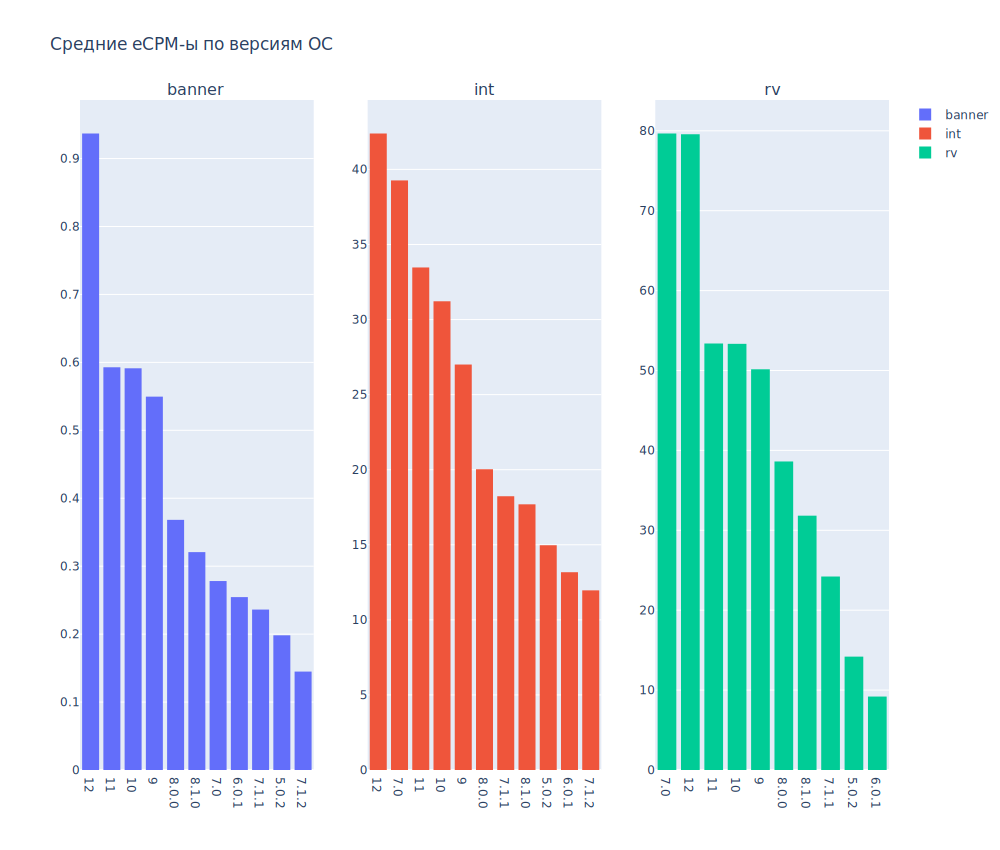

In [18]:
# график распределния средних по версиям ОС
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Histogram(x=mean_os_banner.os_version,
              y=mean_os_banner.ecpm, name='banner', histfunc='avg'), row=1, col=1)

fig.add_trace(go.Histogram(x=mean_os_int.os_version,
              y=mean_os_int.ecpm, name='int', histfunc='avg'), row=1, col=2)

fig.add_trace(go.Histogram(x=mean_os_rv.os_version, y=mean_os_rv.ecpm,
              name='rv', histfunc='avg'), row=1, col=3)

fig.update_layout(height=850, width=1000,
                  title_text='Cредние eCPM-ы по версиям ОС')
fig.show()

###### Отказ от старых ОС не всегда рентабелен. 

## Cуммарные доходы по городам, версиям ОС

### Суммарные доходы по городам графические

In [19]:
# таюлицы для графика с городами
sum_city_banner = data_banner.groupby('city')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)
sum_city_int = data_int.groupby('city')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)
sum_city_rv = data_rv.groupby('city')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)

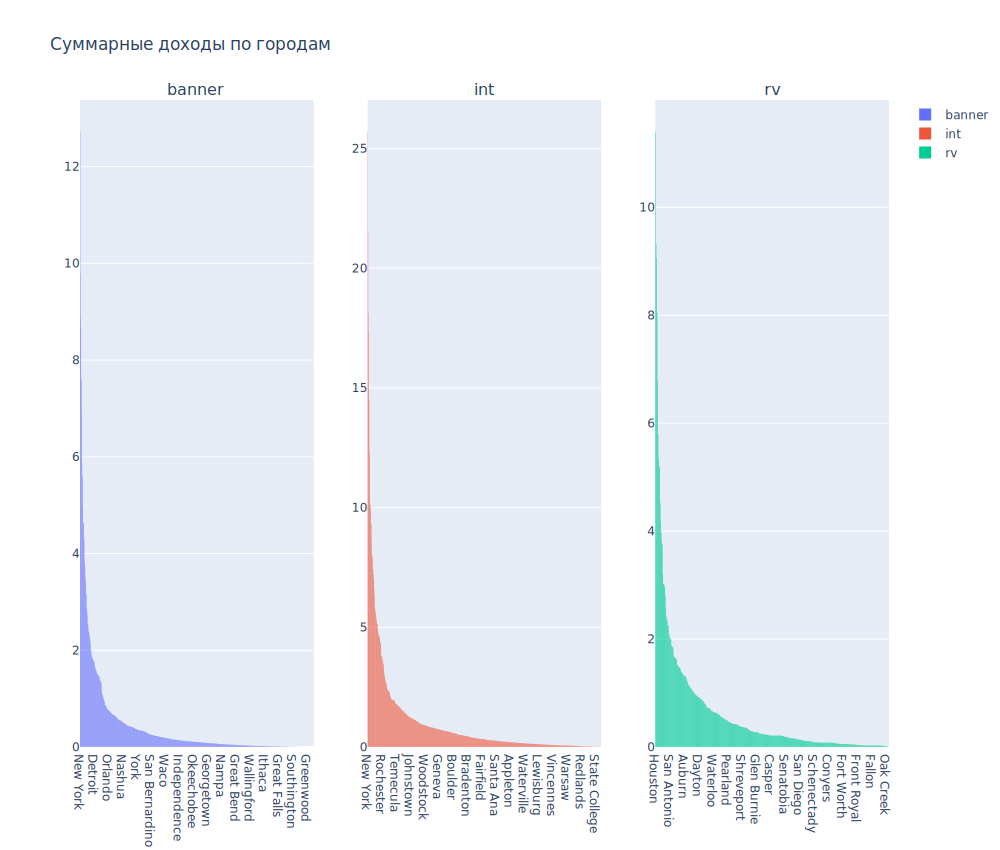

In [20]:
# график распределния средних по городам
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Histogram(x=sum_city_banner.city[1:],
              y=sum_city_banner[1:].revenue, name='banner', histfunc='avg'), row=1, col=1)

fig.add_trace(go.Histogram(x=sum_city_int.city[1:],
              y=sum_city_int.revenue[1:], name='int', histfunc='avg'), row=1, col=2)

fig.add_trace(go.Histogram(x=sum_city_rv.city[1:], y=sum_city_rv.revenue[1:],
              name='rv', histfunc='avg'), row=1, col=3)

fig.update_layout(height=850, width=1000,
                  title_text='Cуммарные доходы по городам')
fig.show()

###### Грфик не отоброжает не заполненные данные ибо они создают огромный перекос

### Суммарные доходы по городам в таблицах

In [21]:
sum_city_banner.head()

,city,revenue
856,Нет данных,234.683644
552,New York,12.708617
366,Indianapolis,9.789215
739,Spokane,8.862484
355,Houston,8.664916


In [22]:
sum_city_int.head()

,city,revenue
869,Нет данных,499.433035
550,New York,25.674272
357,Indianapolis,21.534431
152,Cleveland,18.112861
506,Minneapolis,17.286339


In [23]:
sum_city_rv.head()

,city,revenue
454,Нет данных,136.729384
191,Houston,11.389241
273,Minneapolis,9.319597
296,New York,9.071508
312,Oklahoma City,8.045251


In [24]:
print(f'Сумма доходов с баннеров {round(sum_city_banner.revenue.sum(), 2)}',
      f'Сумма доходов с полноэкранной рекламы {round(sum_city_int.revenue.sum(), 2)}',
      f'Сумма доходов с видео {round(sum_city_rv.revenue.sum(), 2)}',
      f'Общая сумма {round(data.revenue.sum(), 2)}', sep='\n')

Сумма доходов с баннеров 607.18
Сумма доходов с полноэкранной рекламы 1361.95
Сумма доходов с видео 421.66
Общая сумма 2390.8


###### Большая часть доходов идёт из не размеченных данных. В данных большое количество пропусков в столбце с городом

### Cуммарные доходы по версиям ОС графические

In [25]:
# таблицы для графика с ос
sum_os_banner = data_banner.groupby('os_version')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)
sum_os_int = data_int.groupby('os_version')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)
sum_os_rv = data_rv.groupby('os_version')['revenue'].sum(
).reset_index().sort_values('revenue', ascending=False)

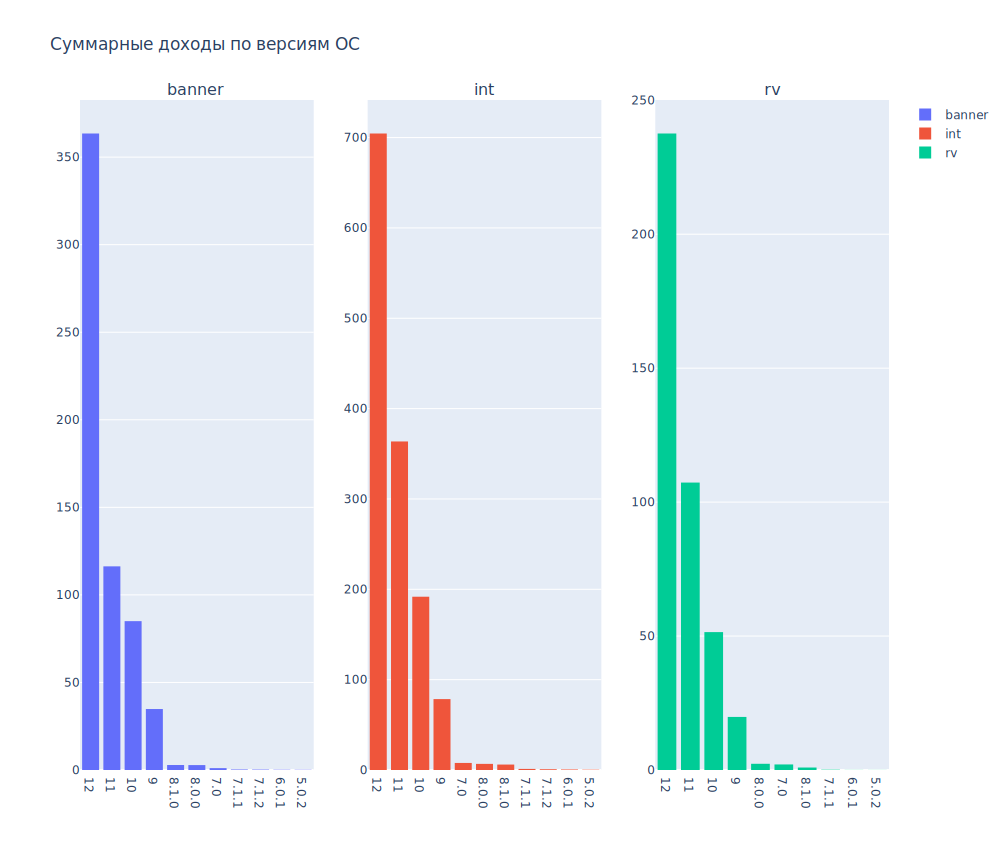

In [26]:
# график распределния средних по версиям ОС
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Histogram(x=sum_os_banner.os_version,
              y=sum_os_banner.revenue, name='banner', histfunc='avg'), row=1, col=1)

fig.add_trace(go.Histogram(x=sum_os_int.os_version,
              y=sum_os_int.revenue, name='int', histfunc='avg'), row=1, col=2)

fig.add_trace(go.Histogram(x=sum_os_rv.os_version, y=sum_os_rv.revenue,
              name='rv', histfunc='avg'), row=1, col=3)

fig.update_layout(height=850, width=1000,
                  title_text='Cуммарные доходы по версиям ОС')
fig.show()

### Cуммарные доходы по версиям ОС табличные

In [27]:
sum_os_banner.head()

,os_version,revenue
2,12,363.488994
1,11,116.298348
0,10,85.002788
10,9,34.820249
9,8.1.0,2.847789


In [28]:
sum_os_int.head()

,os_version,revenue
2,12,704.497187
1,11,363.634932
0,10,191.795052
10,9,78.475755
5,7.0,7.813966


In [29]:
sum_os_rv.head()

,os_version,revenue
2,12,237.592767
1,11,107.291533
0,10,51.470091
9,9,19.809863
7,8.0.0,2.316879


###### Большиство людей своевременно обновляют ОС и их количество сильно преобладает. Особенно такой отрыв видно на  самой новейшей ОС

## Статистическая значимость cредних eCPM по городам, версиям ОС

Статистически значимым значениями является значениями, которые входят в 95%(либо 99%) доверительный интервал. Для его определение можно использовать отклонения на растоянию двух сигм, это стандартное отклонение умноженное на 2(получается откладываемое растояние от среднего значения выборки в обе стороны) или просто квантиль 97,5 верхней границы и квантиль 2,5 нижней границы, которые и отсекут "выбросы"  в данных.

На графиках ниже представленны "ящики с усами" разных видов рекламы рапределённые по городам и средним. `Точки` на графике это города, а по оси `y` идут их срение *eCPM*.

На них добавленны линни показывающие вхождение в 95% интервал. А это зачит, что за пределами этих линий находятся данные статистически не значимые.

### Статистическая значимость cредних eCPM по городам

#### banner

In [30]:
print('Верхняя граница д.и =', mean_city_banner.ecpm.quantile(0.975))
print('Нижняя граница д.и =', mean_city_banner.ecpm.quantile(0.025))

Верхняя граница д.и = 5.530665291739136
Нижняя граница д.и = 0.08994236973411864


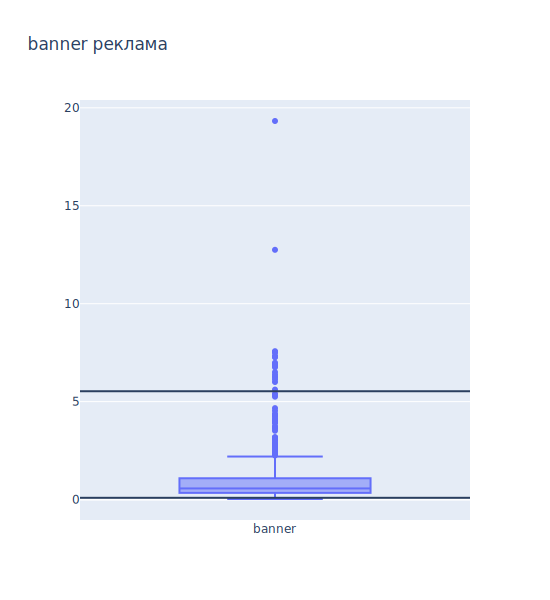

In [31]:
fig = go.Figure()

fig.add_trace(go.Box(y=mean_city_banner.ecpm, name='banner'))
fig.add_hline(y=mean_city_banner.ecpm.quantile(0.975))
fig.add_hline(y=mean_city_banner.ecpm.quantile(0.025))
fig.update_layout(title_text='banner реклама',height=600, width=550)
fig.show()

#### int

In [32]:
print('Верхняя граница д.и =', mean_city_int.ecpm.quantile(0.975))
print('Нижняя граница д.и =', mean_city_int.ecpm.quantile(0.025))

Верхняя граница д.и = 186.56666554768856
Нижняя граница д.и = 8.157251399522714


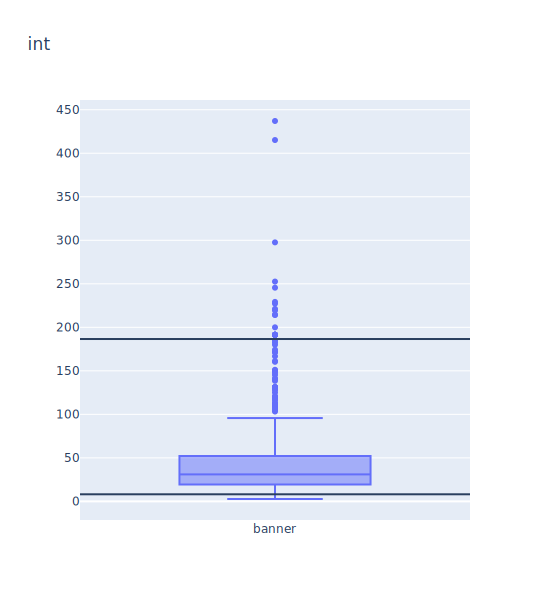

In [33]:
fig = go.Figure()

fig.add_trace(go.Box(y=mean_city_int.ecpm, name='banner'))
fig.add_hline(y=mean_city_int.ecpm.quantile(0.975))
fig.add_hline(y=mean_city_int.ecpm.quantile(0.025))
fig.update_layout(title_text='int',height=600, width=550)
fig.show()

#### rv

In [34]:
print('Верхняя граница д.и =', mean_city_rv.ecpm.quantile(0.975))
print('Нижняя граница д.и =', mean_city_rv.ecpm.quantile(0.025))

Верхняя граница д.и = 221.65012812296493
Нижняя граница д.и = 14.356347208440319


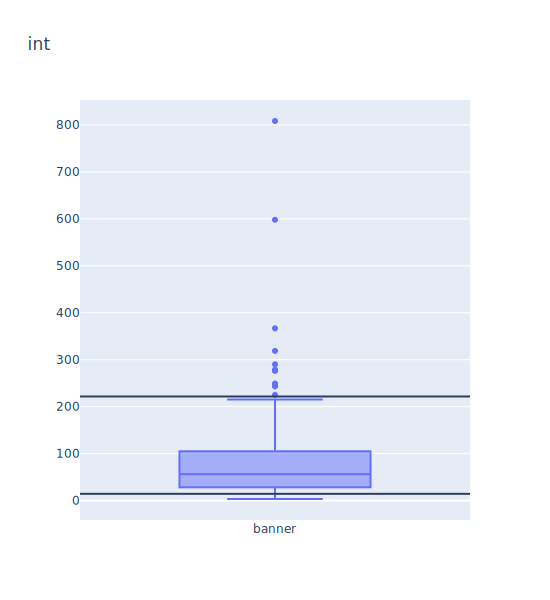

In [35]:
fig = go.Figure()

fig.add_trace(go.Box(y=mean_city_rv.ecpm, name='banner'))
fig.add_hline(y=mean_city_rv.ecpm.quantile(0.975))
fig.add_hline(y=mean_city_rv.ecpm.quantile(0.025))
fig.update_layout(title_text='int',height=600, width=550)
fig.show()

Нижнюю границу на самом деле можно и не трогать. Данные там не сильно отличаются от основной массы, но на боксплотах видно, что выше верхней границы д.и. идут выбросы и от них лучше избавиться.

### Статистическая значимость cредних eCPM версиям ОС

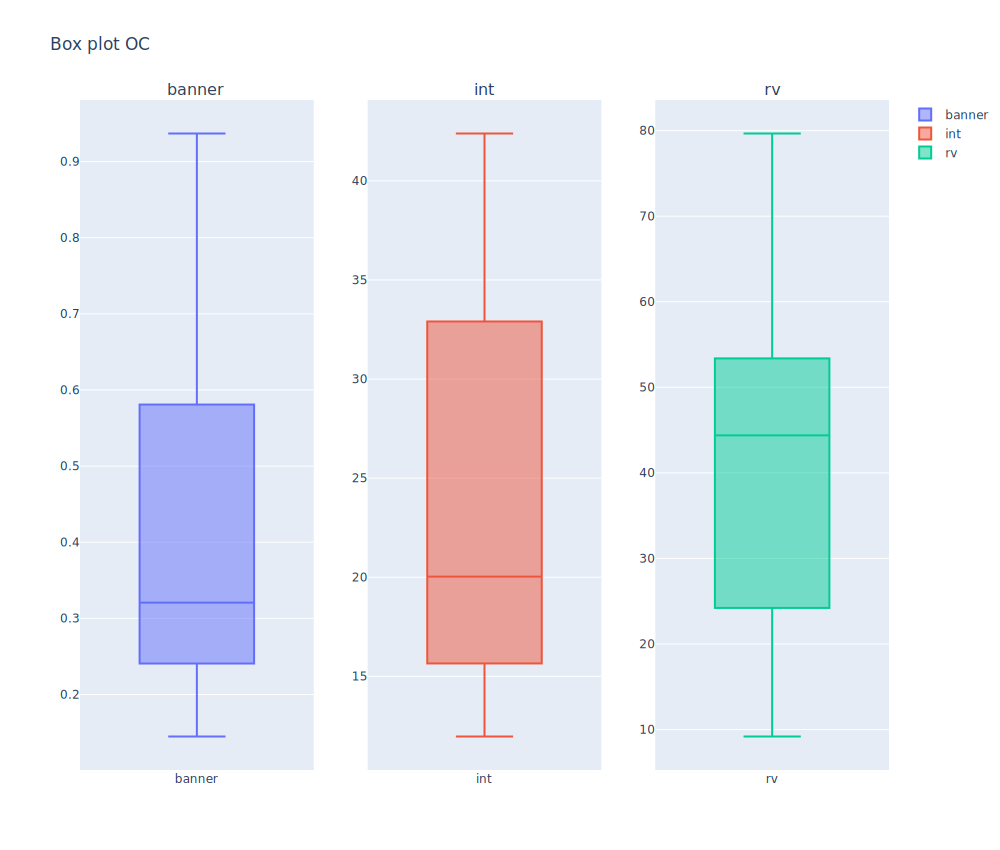

In [36]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('banner', 'int', 'rv'))

fig.add_trace(go.Box(y=mean_os_banner.ecpm, name='banner'), row=1, col=1)

fig.add_trace(go.Box(y=mean_os_int.ecpm, name='int'), row=1, col=2)

fig.add_trace(go.Box(y=mean_os_rv.ecpm, name='rv'), row=1, col=3)

fig.update_layout(height=850, width=1000,
                  title_text='Box plot ОС')
fig.show()

Отличные ящики с усами по версии ОС, говорят нам, что тут выбросов нет.

## Вывод

В данных большое количетсво пропусков в данных о городе, с этим нужно пробовать бороться. Возможн как решение будет обучение ml модели с мультиклассом для городов или найти другую закономерность в данных для их заполнения.

Ориентироваться на города и ос с самой большой доходность не имеет смысла ибо оно обусловленно количеством юзеров.

А вот посмотреть на средние eCPM очень даже стоит. Но после того, как уберём выбросы по городам, они возникают из-за малого количества юзеров из этих городов и по-этому их значение не усредняется.

И в ос мы сразу видим, что поддерживать `версию ос 7` точно нужно, хоть она и не относиться к новейшим.


*Итак мы имеем:*


+ Процент горизонтальных баннеров : 94.87, доход 607.18

+ Процент полноэкранной рекламы : 4.37,  доход 1361.95

+ Процент видео, которое юзер смотрит по желанию : 0.75, доход 421.66


Очевидно, что заманить юзера на просмотр видео с рекламой будет очень кстати.

